In [3]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
import scipy.stats
import matplotlib as mpl
import errno
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import os
mpl.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [6]:
Mb = 1000000
minval = 50
maxval = 90

# Get zscore
def GetZscore(data, col):
    m = np.mean(data[col])
    s = np.sqrt(np.var(data[col]))
    return data.apply(lambda x: (x[col]-m)/s, 1)    

# get ratio of readcount in data and background 
def get_ratio(data, background, i):
    # data/background
    data["ratio"] = data["norm_readcount"]/background['norm_readcount']
    
    m = np.mean(data["ratio"])
    s = np.sqrt(np.var(data["ratio"]))
    
    print(i, m, m+3*s, m-3*s)
    print(sum(data['readcount']))
    
    # get rid of extrme values
    data = data[data["ratio"]<=m+3*s]
    data = data[data["ratio"]>=m-3*s] 

#     data["zscore"] = GetZscore(data, "ratio")
    return data

# read in data
def read_data (exp,histone):
    data_array = []
    if histone != 'WCE':
        kword = 'filtered.clustered.bed'
        path = "./tss_clusters_all/peaksonly/"
    else:
        kword = 'filtered.clustered.bed'
        path = "./tss_clusters_all/peaksonly/"
    file_list = [path+i for i in os.listdir(path) if exp in i and histone in i and kword in i]
    file_list = sorted(file_list)
#     print(file_list)
    background = [path+i for i in os.listdir(path) if exp in i and "0hr" in i and histone in i and kword in i]
    background = pd.read_csv(background[0], sep="\t", names=["chrom","start","end","cluster", "readcount"])
#     background = background[(background.index>=minval*Mb) & (background.index<=maxval*Mb)]
    background = background.set_index(['chrom','start'])
    background['norm_readcount'] = background['readcount']/np.sum(background['readcount'])

    for f in file_list:
#         print(f)
        data = pd.read_csv(f, sep="\t", names=["chrom","start","end","cluster","readcount"])
        data = data.set_index(['chrom','start'])
#         data = data[(data.index>=minval*Mb) & (data.index<=maxval*Mb)]
        print(f)
        hr = "_".join(f.split('/')[-1].split('.')[0].split('_')[0:3])
        
        # normalize readcount
        data['norm_readcount'] = data['readcount']/np.sum(data['readcount'])

        data = get_ratio(data, background, hr)
        
        data = data.reset_index()

        data_array.append((data,hr))
        
    return data_array

# smoothing
def new_smooth(data, window_size = 100000, stepsize = 50000, column = "ratio"):
    newx = []
    newy = []
    i = minval*Mb
    while i < maxval*Mb:
        center = i+stepsize
        x = data[(data.index>=i) & (data['end'] <= i+window_size)]
        i += stepsize
        newx.append(center)
        newy.append(np.sum(x[column]))
    return np.array(newx), np.array(newy)
    

### Load Data

In [7]:
data_array_exp1_K4 = read_data('exp2',"K4me3")
data_array_exp1_WCE = read_data('exp2',"WCE")

# data_array_exp2 = read_data('exp2',"K4me3")

./tss_clusters_all/peaksonly/exp2_0hr_K4me3.filtered.clustered.bed
exp2_0hr_K4me3 1.0 1.0 1.0
1.651530266e+15
./tss_clusters_all/peaksonly/exp2_1hr_K4me3.filtered.clustered.bed
exp2_1hr_K4me3 1.00336217949 1.19380101835 0.81292334063
1.6580614579e+15
./tss_clusters_all/peaksonly/exp2_2hr_K4me3.filtered.clustered.bed
exp2_2hr_K4me3 1.00482781468 1.19187783652 0.817777792833
1.65695764544e+15
./tss_clusters_all/peaksonly/exp2_3hr_K4me3.filtered.clustered.bed
exp2_3hr_K4me3 1.00469228836 1.18648189706 0.82290267966
1.64351000336e+15
./tss_clusters_all/peaksonly/exp2_4hr_K4me3.filtered.clustered.bed
exp2_4hr_K4me3 1.00452689063 1.19262913074 0.81642465051
1.70487698466e+15
./tss_clusters_all/peaksonly/exp2_5hr_K4me3.filtered.clustered.bed
exp2_5hr_K4me3 1.00558724379 1.19836989686 0.812804590723
1.5986206369e+15
./tss_clusters_all/peaksonly/exp2_6hr_K4me3.filtered.clustered.bed
exp2_6hr_K4me3 0.996645573363 1.19156311529 0.801728031435
1.53321476875e+15
./tss_clusters_all/peaksonly/exp2_7h

In [33]:
data = data_array_exp1_K4[1][0]
data[data['cluster']==6]
# data = pd.read_csv('./tss_clusters_all/sum/exp2_0hr_K4me3_HJWMVBGXX.clustersum.bed.rmdup', sep='\t', names=['chrom','start','end','cluster','readcount'])
# data[data[['chrom','start']].duplicated()]

,chrom,start,end,cluster,readcount,norm_readcount,ratio
205,chr2,115330889,115906134,6,2.448944e+11,0.000148,0.919455
228,chr2,134366722,138146122,6,1.129122e+12,0.000682,0.992601
277,chr3,3460322,6687295,6,1.564615e+10,0.000009,1.050834
278,chr3,7443670,7577206,6,1.704068e+10,0.000010,1.010852
312,chr3,80514266,82421183,6,2.244478e+11,0.000136,1.138814
345,chr3,117354307,119563663,6,3.294228e+11,0.000199,1.043460
349,chr3,124315591,126302000,6,4.727409e+11,0.000286,1.035430
371,chr3,154657200,156871339,6,5.642416e+11,0.000341,0.824695
377,chr4,4649473,5819727,6,1.107293e+10,0.000007,0.999565
389,chr4,26273199,30375632,6,8.247311e+10,0.000050,0.986413


Try **ratio** for K4/WCE

In [67]:
def combineK4WCE(K4_array, WCE_array, col ):
    combined = []
    for i in range(len(WCE_array)):
        K4=K4_array[i][0][['chrom','start',col,'cluster']]
        WCE=WCE_array[i][0][['chrom','start',col,'cluster']]
        combine = K4[['chrom','start','cluster']]
        combine['K4toWCE']=K4[col]/WCE[col]
        combine = combine.sort_values(['cluster'])
        combined.append(combine)
    return combined

In [68]:
combined_ratio = combineK4WCE(data_array_exp1_K4, data_array_exp1_WCE, 'ratio')
combined_readcount = combineK4WCE(data_array_exp1_K4, data_array_exp1_WCE, 'norm_readcount')

In [69]:
# real_combine = data_array_exp1_K4[0][0][['chrom','start','cluster','ratio',]].sort_values('cluster')
real_combine = combined_ratio[0]

for i in range(1,9):
    c = combined_ratio[i]
#     print(data_array_exp1_WCE[i][1])
#     c = data_array_exp1_K4[i][0][['chrom','start','cluster','ratio']].sort_values('cluster')
    real_combine = pd.merge(real_combine, c, how='inner',on=['chrom','start','cluster'],suffixes=('_'+str(i-1), '_'+str(i)))
# del real_combine['cluster']

In [70]:
real_combine = real_combine.drop(real_combine.index[real_combine[['start','chrom']].duplicated()])
real_combine = real_combine.set_index(['chrom','start']).dropna()
# real_combine = real_combine[real_combine['cluster'] ==1]
# del real_combine['cluster']
# real_combine

In [71]:
# # np.max(real_combine[''].values)-np.min(real_combine['ratio_1'].values)
# for i in real_combine:
#     real_combine[i] = np.log10(real_combine[i])
# #     print(np.min(real_combine[i].values))
real_combine.loc[real_combine['cluster'] <=7, 'region'] = 'Late'
real_combine.loc[real_combine['cluster'] <=5 , 'region'] = 'Middle'
real_combine.loc[real_combine['cluster'] <3, 'region'] = 'Early'
real_combine.loc[real_combine['cluster'] == 8, 'region'] = 'Asynchronized'

In [72]:
real_combine = real_combine.reset_index()
del real_combine['start']
del real_combine['chrom']
del real_combine['cluster']
# real_combine

In [73]:
mean = real_combine.groupby(['region']).mean()
# del mean['chrom']
mean = mean.reindex(['Early', 'Middle', 'Late', 'Asynchronized'])
mean

,K4toWCE_0,K4toWCE_1,K4toWCE_2,K4toWCE_3,K4toWCE_4,K4toWCE_5,K4toWCE_6,K4toWCE_7,K4toWCE
region,,,,,,,,,
Early,1.0,1.020347,1.009708,0.992072,0.990667,1.001294,0.991236,0.988513,0.985316
Middle,1.0,1.030404,1.005858,0.998082,0.998800,1.008826,0.982534,0.979804,0.977173
Late,1.0,1.038708,1.063842,0.992692,1.014275,0.999370,0.965231,0.928862,1.013875
Asynchronized,1.0,1.008584,1.004178,1.007561,0.988075,1.007929,1.014148,0.988904,1.000248


In [74]:
# real_combine.to_csv('./plotting/K4toWCEratio_filtered_all.csv', index=True)
# real_combine 

In [75]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('red'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue')])
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


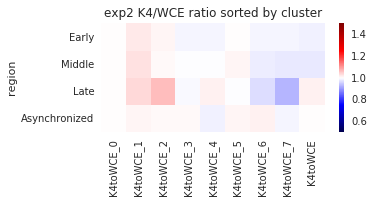

In [77]:
f, ax = plt.subplots(figsize=(5,2))
ax.set_title('exp2 K4/WCE ratio sorted by cluster')
cmap=ListedColormap(sns.diverging_palette(250, 5, n=255))
ax = sns.heatmap(mean,
                 yticklabels=True, 
                 vmin=0.5,
                 vmax=1.5, 
                 cmap="seismic",
                )

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


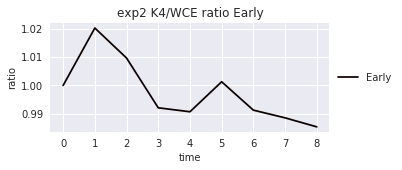

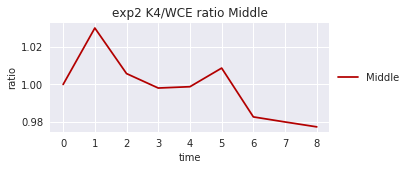

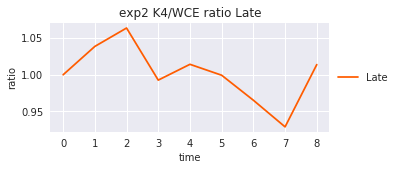

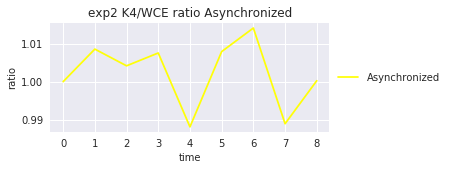

In [78]:
# f, ax = plt.subplots(figsize=(8,5))
# ax.set_title('exp2 K4 sorted by cluster')
jet = cm = plt.get_cmap('hot') 
    
cNorm  = mpl.colors.Normalize(vmin=0, vmax=4)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
j = 0
for i in mean.index:
    colorVal = scalarMap.to_rgba(j)
    f, ax = plt.subplots(figsize=(5,2))
    ax.set_title('exp2 K4/WCE ratio ' + str(i))
    ax.plot(list(mean.loc[i]), label = str(i), color = colorVal)
    
    j+=1
    
    handles,labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("time", size=10);
    ax.set_ylabel("ratio", size=10);

# ax.set_ylim(bottom=0, top=2)

# plt.xticks(range(0,9), mean.columns.values)

### Ratio Distribution

/usr/lib64/python3.4/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/lib64/python3.4/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


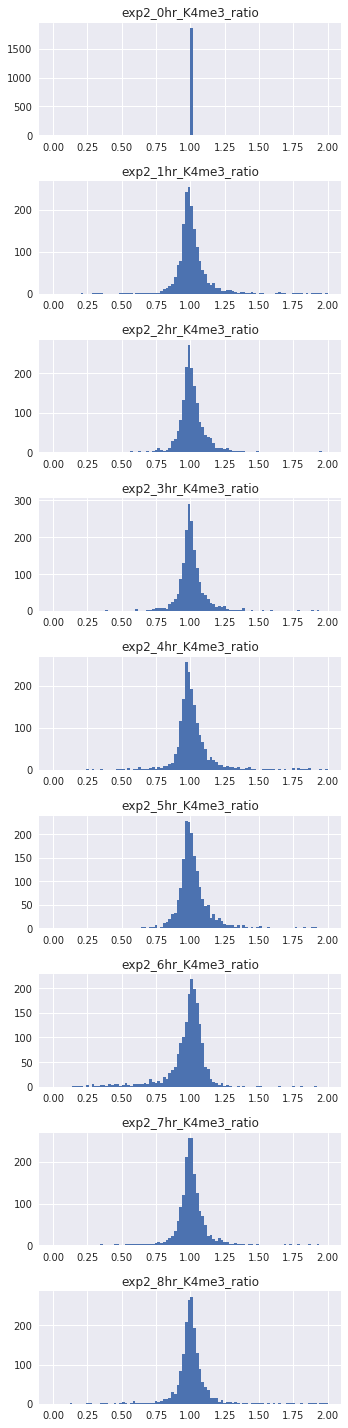

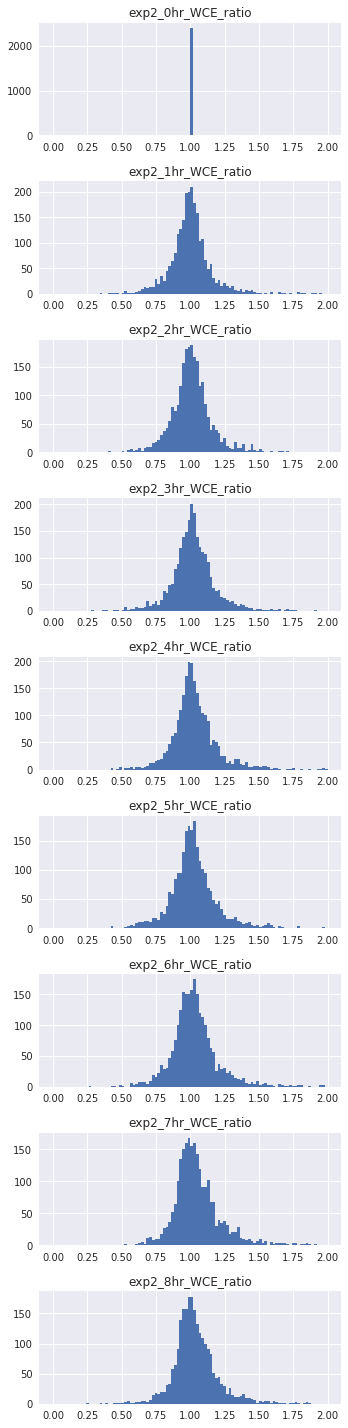

In [15]:
fig = plt.figure()

i = 0
for data in data_array_exp1_K4:
    ax = fig.add_subplot(9,1,i+1)
    ax.title.set_text(data[1]+'_ratio')
    ax.hist(data[0]["ratio"], bins=100, range=(0,2))
    
    i+=1
fig.set_size_inches(5,20, forward=True)
fig.tight_layout()
    
fig = plt.figure()
i = 0
for data in data_array_exp1_WCE:
    ax = fig.add_subplot(9,1,i+1)
    ax.title.set_text(data[1]+'_ratio')
    ax.hist(data[0]["ratio"], bins=100, range=(0,2))
    
    i+=1
    
fig.set_size_inches(5,20, forward=True)
fig.tight_layout()

,chrom,start,end,readcount,cluster,K4toWCE
0,chr2,50150197,50154197,35979,5,60.367450
1,chr2,50150329,50154329,35942,5,56.870253
2,chr2,51002631,51006631,225,6,1.004464
3,chr2,51585529,51589529,225,4,1.500000
4,chr2,51788164,51792164,32877,4,79.605327
5,chr2,51826728,51830728,19016,4,50.709333
6,chr2,51926356,51930356,31713,8,53.120603
7,chr2,52144521,52148521,150,4,0.286260
8,chr2,52192318,52196318,149,4,0.398396
9,chr2,52278394,52282394,27752,4,730.315789


### TSS Ratio Plot

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


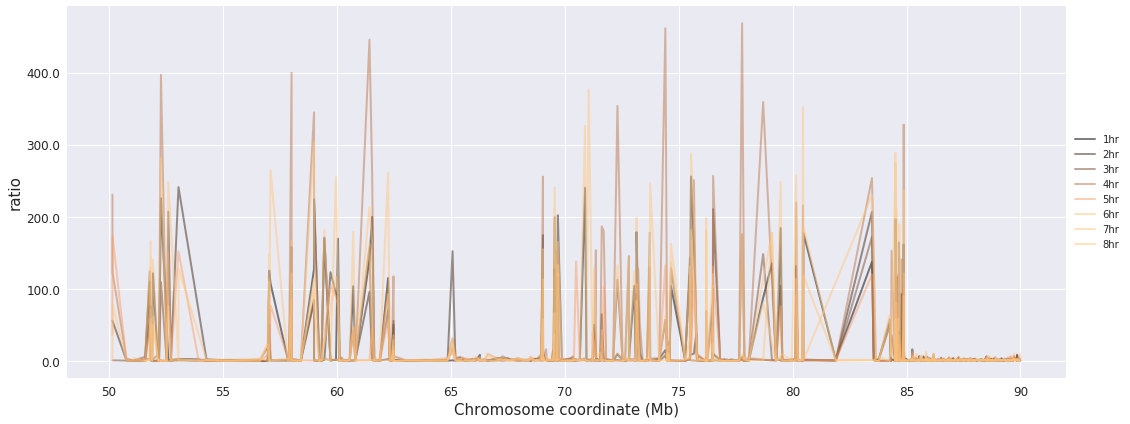

In [166]:
fig = plt.figure()
ax = fig.add_subplot(111)

# get color scheme
jet = cm = plt.get_cmap('copper') 

cNorm  = mpl.colors.Normalize(vmin=0, vmax=5)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)

i = 0

# for data in data_array_exp1:
for i in range(len(data_array_exp1)):
    data = data_array_exp1[i][0]
    
#     data = data[(data['start'] >= 80* Mb) & (data['start'] <= 85* Mb) ]
#     data = data[data['ratio']<=5]

    colorVal = scalarMap.to_rgba(i)
    colorText = ('color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2]))
    ax.plot(list(data['start']), list(data['ratio']), color=colorVal, lw=2, label=str(i+1)+"hr", alpha = 0.5)
    
#     i+=1
# ax.set_xlim(left=minval*Mb, right=maxval*Mb);
# ax.set_ylim(bottom=0, top=300)
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_ylabel("ratio", size=15);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(15,6, forward=True)
fig.tight_layout()

### Smoothed Ratio Plot

In [146]:
xarray_exp1 = []
yarray_exp1 = []

# smooth exp1
for data in data_array_exp2:
    xnew, ynew = new_smooth(data[0])
    xarray_exp1.append(xnew)
    yarray_exp1.append(ynew)


/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


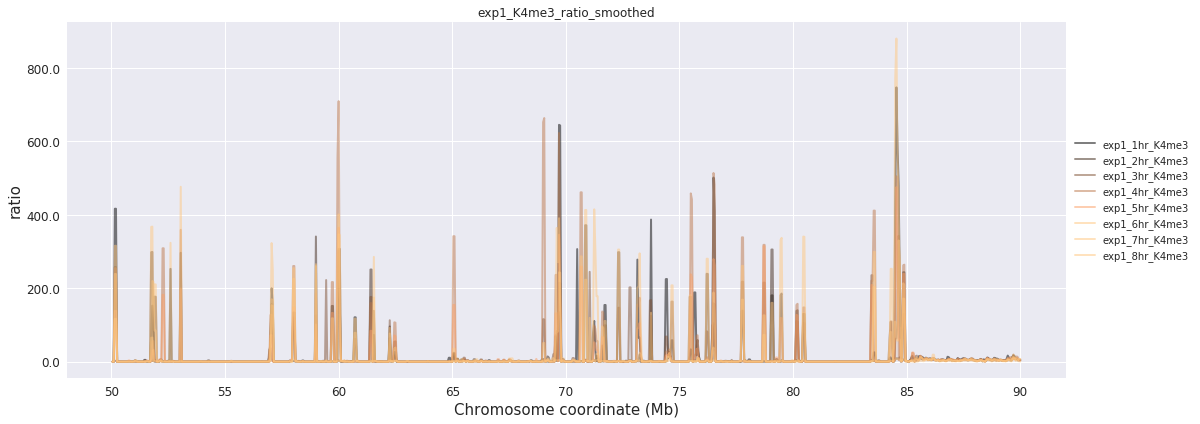

In [147]:
fig = plt.figure()
lines = []

ax = fig.add_subplot(111)

jet = cm = plt.get_cmap('copper') 
cNorm  = mpl.colors.Normalize(vmin=0, vmax=5)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)


ax.set_title("exp1_K4me3_ratio_smoothed")

i = 0
for data in data_array_exp1:
        
    xnew, ynew = xarray_exp1[i],yarray_exp1[i]

    colorVal = scalarMap.to_rgba(i)
    colorText = ('color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2]))
    retLine, = ax.plot(list(xnew),list(ynew),color=colorVal,label=data[1], linewidth = 2, alpha = 0.5)
    lines.append(retLine)
    i+=1

# ax.set_xlim(left=minval*Mb, right=maxval*Mb);
# ax.set_ylim(bottom=0, top=0.5)
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_ylabel("ratio", size=15);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(15,6, forward=True)
fig.tight_layout()
# fig.savefig("exp1_WCE_combined.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

## Sum up peaks in larger windows

In [88]:
def merge_peaks(df):
#     minVal = 50
#     maxVal = 90
#     Mb = 1000000
    stepsize=20000
    windowsize=40000
    num_windows = (maxval - minval) // (stepsize//10000) * 100 -1
    bins = np.ndarray(shape=(9,num_windows))
    start_pos = np.arange(minval * Mb, maxval * Mb-100000+1, stepsize)
    end_pos = np.arange(minval * Mb+100000, maxval * Mb+1, stepsize)
    df_ind = 0
    for i in range(num_windows):
        start = i*stepsize + minval*Mb
        end = start + windowsize
        for j in range(1,9):
            bins[j-1][i] = np.sum(df[(df['start'] > start) & (df['end'] <= end) & (df['cluster'] == j)]['norm_readcount'])
    return bins

In [89]:
merge_peaks(data[0].reset_index())

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.94569496e-05],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [10]:
f = open("./regions_sep/exp1_0hr_K4me3.regions.txt")
df = pd.read_csv(f, sep='\t', names=["peakID", "chr", "start","end", "readcount"])

In [11]:
df = df.sort_values(["start","end"])

In [12]:
bins = np.zeros_like(np.arange(799))
start_pos = np.arange(minVal * Mb, maxVal * Mb-100000+1, stepsize)
end_pos = np.arange(minVal * Mb+100000, maxVal * Mb+1, stepsize)

In [13]:
df_ind = 0
for i in range(num_windows):
    start = i*stepsize + minVal*Mb
    end = start + windowsize
    bins[i] = np.sum(df[(df['start'] > start) & (df['end'] <= end)]['readcount'])

In [14]:
new_df = pd.DataFrame(data=collections.OrderedDict({"start": start_pos, "end":end_pos, "readcount": bins}))
new_df = new_df[['start', 'end', 'readcount']]

In [15]:
# new_df.to_csv("./test.regions.bed", sep="\t")
new_df

,start,end,readcount
0,50000000,50100000,27
1,50050000,50150000,0
2,50100000,50200000,596
3,50150000,50250000,596
4,50200000,50300000,0
5,50250000,50350000,0
6,50300000,50400000,0
7,50350000,50450000,0
8,50400000,50500000,0
9,50450000,50550000,0


/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


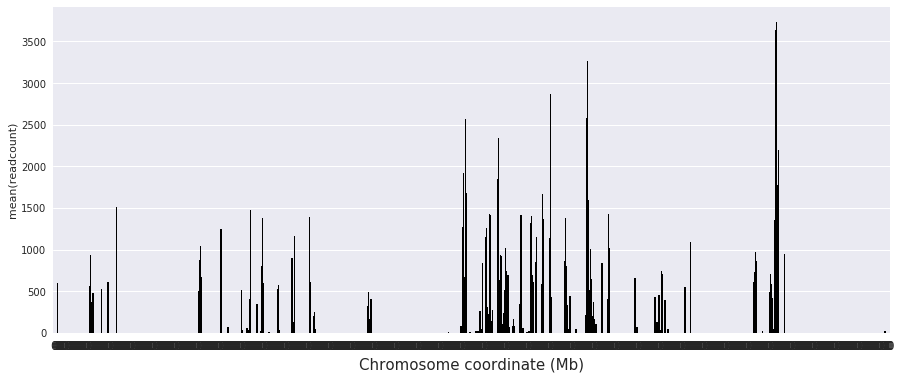

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.barplot(x="start", y="readcount", data=new_df,color="black")

# ax.set_xlim(left=minVal*Mb, right=maxVal*Mb);
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
fig.set_size_inches(15,6, forward=True)